In [2]:
import sys
import pandas as pd

sys.path.append('/opt/hydra/')

import library.analysis as hydra

In [3]:
exp_path = '../data/treehouse-synovial-log2TPM1-V9.tsv'
mm_path = '../data/synovial-output/MultiModalGenes'

In [4]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [5]:
exp.shape

(16426, 36)

In [6]:
import numpy as np

sweep_terms = {}
sweep_genes = {}
for x in np.linspace(0.3, 0.45, 6):

    mm = hydra.EnrichmentAnalysis(mm_path,
                                  exp_path,
                                  min_prob_filter=x,
                                  gmt_path='GO')
    
    print 'Min Prob: ', x
    print 'Num Genes: ', len(mm.get_enriched_term_genes())
    print mm.get_enriched_terms()
    print
    
    sweep_terms[x] = mm.get_enriched_terms()
    sweep_genes[x] = mm.get_enriched_term_genes()

Min Prob:  0.3
Num Genes:  37
   Unnamed: 0          ID                                        Description  \
0  GO:0007389  GO:0007389                      pattern specification process   
1  GO:0003002  GO:0003002                                    regionalization   
2  GO:0032352  GO:0032352   positive regulation of hormone metabolic process   
3  GO:0098742  GO:0098742  cell-cell adhesion via plasma-membrane adhesio...   
4  GO:0007600  GO:0007600                                 sensory perception   

  GeneRatio    BgRatio        pvalue      p.adjust        qvalue  \
0    23/104  333/11960  7.067385e-15  8.325170e-12  7.237086e-12   
1    21/104  266/11960  8.708337e-15  8.325170e-12  7.237086e-12   
2     3/104   10/11960  7.332763e-05  2.417283e-03  2.101349e-03   
3     7/104  147/11960  2.885889e-04  6.647975e-03  5.779098e-03   
4     9/104  254/11960  3.617964e-04  8.235176e-03  7.158854e-03   

                                              geneID  Count  
0  IRX1/IRX2/GATA4

ValueError: No multimodal genes were identified.
 Try using a lower minimum component probability threshold.

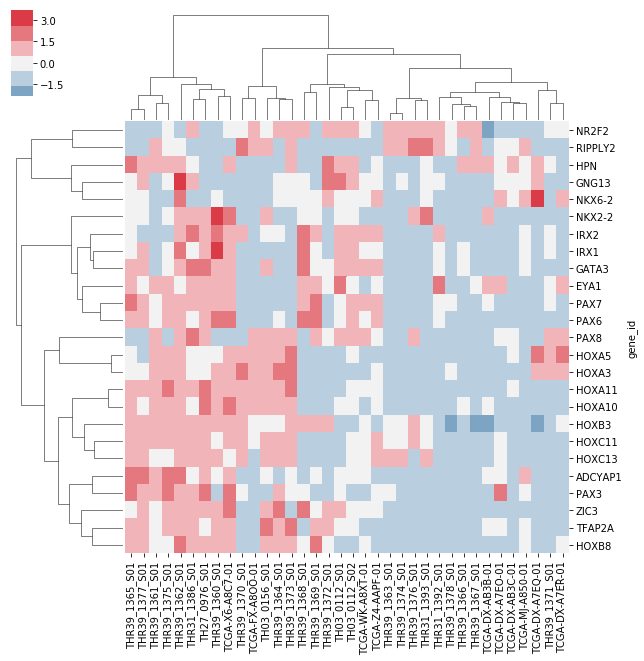

In [27]:
hclust = hydra.HClust(exp.reindex(sweep_genes[0.33]))
hclust.plot()

In [10]:
sweep_assign = {}
for key, genes in sweep_genes.items():
    clus = hydra.MultivariateMixtureModel(data=exp.reindex(genes),
                                          center=True,
                                          gamma=5.0,
                                          variance=2.0,
                                          K=1)
    
    print 'Min Prob: ', key
    print 'Num Genes: ', len(genes) 
    print len(clus.hmodel.allocModel.get_active_comp_probs())
    sweep_assign[key] = clus.get_assignments(exp.reindex(genes))

DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
DELETE @ lap 2.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 3.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 4.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 5.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 6.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 7.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 8.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 9.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 10.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 11.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 12.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 13.00: Ineligible. Did not find >= 2 UIDs in entire model.
Min Prob:  0.4200000

In [11]:
import uuid
import subprocess
from scipy.stats import ttest_ind

sweep_cluster_gsea = {}
for key, assign in sweep_assign.items():
    print key
    sweep_cluster_gsea[key] = {}
    
    if max(assign) == 0:
        continue 
        
    for group in sorted(list(set(assign))):
        ins = []
        outs = []
        for sample, _assign in zip(exp.columns, assign):
            if _assign == group:
                ins.append(sample)
            
            else:
                outs.append(sample)
                
        res = ttest_ind(exp[ins].values,
                        exp[outs].values,
                        axis=1).statistic
        
        tstats = pd.DataFrame(index=exp.index, 
                              data=res).dropna()
            
        tstats = tstats.sort_values(0, 
                                    ascending=False).reset_index()
        
        fname = '/tmp/%s' % str(uuid.uuid4())
        rname = '/tmp/%s' % str(uuid.uuid4())
        tstats.to_csv(fname,
                      header=None,
                      sep='\t',
                      index=False)
            
        cmd = ["Rscript",
               "/opt/hydra/bin/fgsea.R",
               "/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt",
               fname,
               rname]
                
        subprocess.check_call(cmd)
        fgsea = pd.read_csv(rname)
        sweep_cluster_gsea[key][group] = fgsea[fgsea['padj'] < 0.05].sort_values('NES', ascending=False)

0.42000000000000004
0.36
0.3
0.39
0.33


In [13]:
sweep_cluster_gsea[0.33][0].head(10)

,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
365,NABA_CORE_MATRISOME%MSIGDB_C2%NABA_CORE_MATRISOME,0.000137,0.003005,0.485160,3.607788,0,197,IGFBP6|COL11A1|VCAN|SRPX|COL12A1|PODNL1|FMOD|A...
556,NABA_ECM_GLYCOPROTEINS%MSIGDB_C2%NABA_ECM_GLYC...,0.000137,0.003005,0.485357,3.376430,0,139,IGFBP6|SRPX|ANOS1|POSTN|RSPO3|TNXB|SLIT2|NTN4|...
767,HALLMARK_TNFA_SIGNALING_VIA_NFKB%MSIGDB_C2%HAL...,0.000136,0.003005,0.441879,3.203720,0,171,HES1|CEBPB|SDC4|CDKN1A|PHLDA2|LITAF|NR4A3|GADD...
2806,KERATINIZATION%REACTOME DATABASE ID RELEASE 66...,0.000140,0.003005,0.674087,3.201571,0,33,KRT19|PKP3|PKP2|KRT7|KLK8|KRT15|KRT18|PRSS8|CA...
8417,CORNIFICATION%GOBP%GO:0070268,0.000139,0.003005,0.669887,3.157511,0,32,KRT19|PKP3|PKP2|KRT7|KRT15|KRT18|PRSS8|CAPNS1|...
770,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION%MSI...,0.000136,0.003005,0.422574,3.104396,0,183,COL11A1|TNFRSF12A|FZD8|VCAN|TIMP1|COL12A1|EMP3...
6316,EXTRACELLULAR MATRIX ORGANIZATION%GOBP%GO:0030198,0.000136,0.003005,0.416491,3.098146,0,196,COL11A1|VCAN|TIMP1|FLRT2|COL12A1|SCX|SULF2|COL...
11802,KERATINIZATION%GOBP%GO:0031424,0.000140,0.003005,0.649588,3.085214,0,33,KRT19|PKP3|PKP2|KRT7|KRT15|KRT18|PRSS8|CAPNS1|...
7989,EXTRACELLULAR STRUCTURE ORGANIZATION%GOBP%GO:0...,0.000137,0.003005,0.404678,3.056265,0,216,COL11A1|VCAN|TIMP1|FLRT2|COL12A1|SCX|SULF2|COL...
361,NABA_SECRETED_FACTORS%MSIGDB_C2%NABA_SECRETED_...,0.000137,0.003005,0.429481,2.992474,0,141,FGF13|PTN|S100A6|SCUBE2|CBLN1|CTF1|SCUBE1|FGF1...


In [15]:
sweep_cluster_gsea[0.33][1].head(30)

,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
777,HALLMARK_E2F_TARGETS%MSIGDB_C2%HALLMARK_E2F_TA...,0.000131,0.003303,0.653281,4.826889,0,200,CDC25A|MKI67|DLGAP5|DEPDC1|CENPE|HMMR|AURKA|MY...
729,HALLMARK_G2M_CHECKPOINT%MSIGDB_C2%HALLMARK_G2M...,0.000131,0.003303,0.614562,4.525308,0,196,CDC25A|KIF15|CCNF|MKI67|CENPE|HMMR|AURKA|NDC80...
758,HALLMARK_MYC_TARGETS_V1%MSIGDB_C2%HALLMARK_MYC...,0.000131,0.003303,0.549962,4.063498,0,200,CCNA2|MYC|GNL3|RFC4|NAP1L1|NOP56|MAD2L1|EIF4A1...
15153,CHROMOSOME SEGREGATION%GOBP%GO:0007059,0.000131,0.003303,0.526728,3.844917,0,187,SGOL1|KIF18A|NCAPG|MEIOB|DLGAP5|CENPE|CEP55|ND...
1483,"CELL CYCLE, MITOTIC%REACTOME%R-HSA-69278.3",0.000130,0.003303,0.439317,3.743606,0,473,CDC25A|SGOL1|NUP210|MCM10|KIF18A|NCAPG|CENPE|C...
16296,TRANSLATIONAL INITIATION%GOBP%GO:0006413,0.000129,0.003303,0.555145,3.729893,0,123,TICRR|EIF4A1|EIF3M|RPL29|RPL15|RPSA|RPS7|EIF2S...
10099,NUCLEAR CHROMOSOME SEGREGATION%GOBP%GO:0098813,0.000130,0.003303,0.529241,3.703680,0,150,SGOL1|KIF18A|NCAPG|MEIOB|DLGAP5|CENPE|CEP55|ND...
12047,DNA REPLICATION%GOBP%GO:0006260,0.000130,0.003303,0.518399,3.682909,0,162,TICRR|MCM10|PIF1|KIAA0101|DNA2|RFC4|CLSPN|NAP1...
2116,RESOLUTION OF SISTER CHROMATID COHESION%REACTO...,0.000129,0.003303,0.568113,3.668974,0,103,SGOL1|KIF18A|CENPE|NDC80|NUF2|CENPN|CCNB1|CCNB...
1355,MITOTIC PROMETAPHASE%REACTOME DATABASE ID RELE...,0.000131,0.003303,0.505135,3.655727,0,178,SGOL1|KIF18A|NCAPG|CENPE|NDC80|NUF2|CENPN|CCNB...


In [18]:
assign = pd.DataFrame(columns=['sample', 'cluster'])
for s, a in zip(exp.columns, sweep_assign[0.33]):
    assign.loc[len(assign), :] = [s, a + 1]
    
assign = assign.set_index('sample')

In [19]:
assign.to_csv('synovial-hydra-assignments.tsv',
                                  sep='\t')

In [20]:
pth = '../data/synovial-fusion.tsv'
fusion = pd.read_csv(pth, sep='\t', index_col=0)

In [21]:
assign

,cluster
sample,
TH03_0112_S01,1
TH03_0112_S02,1
THR39_1360_S01,1
THR39_1361_S01,1
THR39_1362_S01,1
THR39_1363_S01,2
THR39_1364_S01,2
THR39_1365_S01,1
THR39_1366_S01,1


In [22]:
m = [[0, 0], [0, 0]]
for sample in assign.index.values:
    if sample == 'TCGA-DX-A7EQ-01':
        continue
    c = assign.loc[sample, 'cluster']
    f = fusion.loc[sample, 'fusion']
    if f == 'SSX1':
        m[1][c - 1] += 1
        
    elif f == 'SSX2':
        m[0][c - 1] += 1
    
    else:
        raise ValueError()

In [23]:
m

[[9, 2], [18, 6]]

In [27]:
"""
> library(stats)
> library(base)
> x <- rbind(c(4, 5, 2), c(13, 5, 6))
> x
     [,1] [,2] [,3]
[1,]    4    5    2
[2,]   13    5    6
> fisher.test(x)

	Fisher's Exact Test for Count Data

data:  x
p-value = 0.3237
alternative hypothesis: two.sided
"""

"\n> library(stats)\n> library(base)\n> x <- rbind(c(4, 5, 2), c(13, 5, 6))\n> x\n     [,1] [,2] [,3]\n[1,]    4    5    2\n[2,]   13    5    6\n> fisher.test(x)\n\n\tFisher's Exact Test for Count Data\n\ndata:  x\np-value = 0.3237\nalternative hypothesis: two.sided\n"

In [28]:
fusion_samples = {'SSX1': [], 'SSX2': []}

In [24]:
import collections

genes = sweep_genes[0.33]
clus = hydra.MultivariateMixtureModel(data=exp.reindex(genes),
                                      center=True,
                                      gamma=5.0,
                                      variance=2.0,
                                      K=1)


sample_enrich = {}
sig_gene_sets = collections.Counter()
for sample in exp.columns:
    print(sample)
    
    c, res = clus.sub_cluster_gsea(exp[sample],
                                   gmt="/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt")
    
    print(res.sort_values('NES', ascending=False).head())
    
    mask = (res['padj'] < 0.05) & (res['ES'] > 0)
    sigs = res[mask]
    
    
    sig_gene_sets.update(sigs.index.values)
    
    sample_enrich[sample] = res

DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
DELETE @ lap 2.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 3.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 4.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 2 have past failures.
DELETE @ lap 5.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 2 have past failures.
DELETE @ lap 6.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 2 have past failures.
DELETE @ lap 7.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 2 have past failures.
DELETE @ lap 8.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 9.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 10.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 2 have past failures.
DELETE @ lap 11.00: Empty plan. 0 UIDs eligible as delete ta

                                                        pval      padj   ES  \
pathway                                                                       
GPCR DOWNSTREAM SIGNALLING%REACTOME DATABASE ID...  0.004667  0.513827  1.0   
GPCR LIGAND BINDING%REACTOME DATABASE ID RELEAS...  0.004667  0.513827  1.0   
CLASS B 2 (SECRETIN FAMILY RECEPTORS)%REACTOME ...  0.004667  0.513827  1.0   
GLUCAGON-TYPE LIGAND RECEPTORS%REACTOME DATABAS...  0.004667  0.513827  1.0   
SIGNALING BY GPCR%REACTOME%R-HSA-372790.3           0.004667  0.513827  1.0   

                                                         NES  nMoreExtreme  \
pathway                                                                      
GPCR DOWNSTREAM SIGNALLING%REACTOME DATABASE ID...  1.784449            42   
GPCR LIGAND BINDING%REACTOME DATABASE ID RELEAS...  1.784449            42   
CLASS B 2 (SECRETIN FAMILY RECEPTORS)%REACTOME ...  1.784449            42   
GLUCAGON-TYPE LIGAND RECEPTORS%REACTOME DATABAS...  1.78

                                                        pval      padj  \
pathway                                                                  
NEGATIVE REGULATION OF EPITHELIAL CELL PROLIFER...  0.001189  0.578813   
REGULATION OF EPITHELIAL CELL PROLIFERATION%GOB...  0.001189  0.578813   
POSITIVE REGULATION OF HORMONE METABOLIC PROCES...  0.008914  0.578813   
REGULATION OF HORMONE METABOLIC PROCESS%GOBP%GO...  0.008914  0.578813   
POSITIVE REGULATION OF THYROID HORMONE GENERATI...  0.008914  0.578813   

                                                          ES       NES  \
pathway                                                                  
NEGATIVE REGULATION OF EPITHELIAL CELL PROLIFER...  1.000000  2.152435   
REGULATION OF EPITHELIAL CELL PROLIFERATION%GOB...  1.000000  2.152435   
POSITIVE REGULATION OF HORMONE METABOLIC PROCES...  0.909091  1.956759   
REGULATION OF HORMONE METABOLIC PROCESS%GOBP%GO...  0.909091  1.956759   
POSITIVE REGULATION OF THYROID HORMON

                                                        pval      padj  \
pathway                                                                  
ANTERIOR/POSTERIOR PATTERN SPECIFICATION%GOBP%G...  0.000457  0.564507   
ANGIOGENESIS%GOBP%GO:0001525                        0.017584  0.722052   
BLOOD VESSEL MORPHOGENESIS%GOBP%GO:0048514          0.017584  0.722052   
REGIONALIZATION%GOBP%GO:0003002                     0.030249  0.722052   
REGULATION OF TRANSCRIPTION BY RNA POLYMERASE I...  0.031849  0.722052   

                                                          ES       NES  \
pathway                                                                  
ANTERIOR/POSTERIOR PATTERN SPECIFICATION%GOBP%G...  0.952381  2.131461   
ANGIOGENESIS%GOBP%GO:0001525                        0.956522  1.682397   
BLOOD VESSEL MORPHOGENESIS%GOBP%GO:0048514          0.956522  1.682397   
REGIONALIZATION%GOBP%GO:0003002                     0.659985  1.679259   
REGULATION OF TRANSCRIPTION BY RNA PO

                                                        pval     padj  \
pathway                                                                 
METABOLISM OF PROTEINS%REACTOME DATABASE ID REL...  0.010871  0.61652   
SIGNALING PATHWAYS%REACTOME DATABASE ID RELEASE...  0.048323  0.61652   
SIGNAL TRANSDUCTION%GOBP%GO:0007165                 0.048323  0.61652   
REGULATION OF PROTEIN METABOLIC PROCESS%GOBP%GO...  0.048323  0.61652   
SIGNALING%GOBP%GO:0023052                           0.048323  0.61652   

                                                          ES       NES  \
pathway                                                                  
METABOLISM OF PROTEINS%REACTOME DATABASE ID REL...  0.909091  1.891328   
SIGNALING PATHWAYS%REACTOME DATABASE ID RELEASE...  0.714286  1.682842   
SIGNAL TRANSDUCTION%GOBP%GO:0007165                 0.714286  1.682842   
REGULATION OF PROTEIN METABOLIC PROCESS%GOBP%GO...  0.714286  1.682842   
SIGNALING%GOBP%GO:0023052                   

                                                      pval      padj   ES  \
pathway                                                                     
SOMITE ROSTRAL/CAUDAL AXIS SPECIFICATION%GOBP%G...  0.0774  0.735988  1.0   
SOMITE DEVELOPMENT%GOBP%GO:0061053                  0.0774  0.735988  1.0   
ANTERIOR/POSTERIOR AXIS SPECIFICATION%GOBP%GO:0...  0.0774  0.735988  1.0   
GENE REGULATORY NETWORK MODELLING SOMITOGENESIS...  0.0774  0.735988  1.0   
EMBRYONIC AXIS SPECIFICATION%GOBP%GO:0000578        0.0774  0.735988  1.0   

                                                         NES  nMoreExtreme  \
pathway                                                                      
SOMITE ROSTRAL/CAUDAL AXIS SPECIFICATION%GOBP%G...  1.408392           598   
SOMITE DEVELOPMENT%GOBP%GO:0061053                  1.408392           598   
ANTERIOR/POSTERIOR AXIS SPECIFICATION%GOBP%GO:0...  1.408392           598   
GENE REGULATORY NETWORK MODELLING SOMITOGENESIS...  1.408392          

                                                      pval      padj  \
pathway                                                                
NEPHRON TUBULE DEVELOPMENT%GOBP%GO:0072080        0.074659  0.847569   
URETERIC BUD DEVELOPMENT%GOBP%GO:0001657          0.074659  0.847569   
MESONEPHRIC TUBULE MORPHOGENESIS%GOBP%GO:0072171  0.074659  0.847569   
NEPHRON EPITHELIUM MORPHOGENESIS%GOBP%GO:0072088  0.074659  0.847569   
MESONEPHRIC TUBULE DEVELOPMENT%GOBP%GO:0072164    0.074659  0.847569   

                                                        ES       NES  \
pathway                                                                
NEPHRON TUBULE DEVELOPMENT%GOBP%GO:0072080        0.727273  1.468705   
URETERIC BUD DEVELOPMENT%GOBP%GO:0001657          0.727273  1.468705   
MESONEPHRIC TUBULE MORPHOGENESIS%GOBP%GO:0072171  0.727273  1.468705   
NEPHRON EPITHELIUM MORPHOGENESIS%GOBP%GO:0072088  0.727273  1.468705   
MESONEPHRIC TUBULE DEVELOPMENT%GOBP%GO:0072164    0.727273  1.4

                                                        pval      padj  \
pathway                                                                  
CELLULAR COMPONENT ORGANIZATION%GOBP%GO:0016043     0.013282  0.584735   
CELLULAR COMPONENT ORGANIZATION OR BIOGENESIS%G...  0.013282  0.584735   
RESPONSE TO ABIOTIC STIMULUS%GOBP%GO:0009628        0.023773  0.584735   
REGULATION OF APOPTOTIC PROCESS%GOBP%GO:0042981     0.061949  0.584735   
REGULATION OF CELL DEATH%GOBP%GO:0010941            0.061949  0.584735   

                                                          ES       NES  \
pathway                                                                  
CELLULAR COMPONENT ORGANIZATION%GOBP%GO:0016043     0.909091  1.949570   
CELLULAR COMPONENT ORGANIZATION OR BIOGENESIS%G...  0.909091  1.949570   
RESPONSE TO ABIOTIC STIMULUS%GOBP%GO:0009628        0.956522  1.693628   
REGULATION OF APOPTOTIC PROCESS%GOBP%GO:0042981     0.528767  1.611262   
REGULATION OF CELL DEATH%GOBP%GO:0010

                                                        pval     padj  \
pathway                                                                 
REGULATION OF LOCALIZATION%GOBP%GO:0032879          0.009638  0.45861   
CELLULAR RESPONSE TO ORGANIC SUBSTANCE%GOBP%GO:...  0.038932  0.45861   
REGULATION OF SECRETION BY CELL%GOBP%GO:1903530     0.038932  0.45861   
REGULATION OF PEPTIDE SECRETION%GOBP%GO:0002791     0.038932  0.45861   
REGULATION OF PEPTIDE TRANSPORT%GOBP%GO:0090087     0.038932  0.45861   

                                                          ES       NES  \
pathway                                                                  
REGULATION OF LOCALIZATION%GOBP%GO:0032879          0.825810  1.875615   
CELLULAR RESPONSE TO ORGANIC SUBSTANCE%GOBP%GO:...  0.802318  1.629848   
REGULATION OF SECRETION BY CELL%GOBP%GO:1903530     0.802318  1.629848   
REGULATION OF PEPTIDE SECRETION%GOBP%GO:0002791     0.802318  1.629848   
REGULATION OF PEPTIDE TRANSPORT%GOBP%GO:0090

In [25]:
sig_gene_sets

Counter({'ACTIVATION OF ADENYLATE CYCLASE ACTIVITY%GOBP%GO:0007190': 1,
         'ACTIVATION OF TRKA RECEPTORS%REACTOME DATABASE ID RELEASE 66%187015': 1,
         'ADENYLATE CYCLASE-ACTIVATING G PROTEIN-COUPLED RECEPTOR SIGNALING PATHWAY%GOBP%GO:0007189': 1,
         'ADENYLATE CYCLASE-MODULATING G PROTEIN-COUPLED RECEPTOR SIGNALING PATHWAY%GOBP%GO:0007188': 1,
         'AMIDE TRANSPORT%GOBP%GO:0042886': 1,
         'AMMONIUM TRANSPORT%GOBP%GO:0015696': 1,
         'ATP METABOLIC PROCESS%GOBP%GO:0046034': 1,
         'AZOLE TRANSPORT%GOBP%GO:0045117': 1,
         'BASEMENT MEMBRANE DISASSEMBLY%GOBP%GO:0034769': 1,
         'BASEMENT MEMBRANE ORGANIZATION%GOBP%GO:0071711': 1,
         'BEHAVIOR%GOBP%GO:0007610': 1,
         'BEHAVIORAL DEFENSE RESPONSE%GOBP%GO:0002209': 1,
         'BEHAVIORAL FEAR RESPONSE%GOBP%GO:0001662': 1,
         'BLOOD CIRCULATION%GOBP%GO:0008015': 1,
         'CALCIUM ION HOMEOSTASIS%GOBP%GO:0055074': 1,
         'CAMP-MEDIATED SIGNALING%GOBP%GO:0019933': 1,
 